In [431]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn import preprocessing

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [555]:
house_df = pd.read_csv('/Users/houetsu/Downloads/Python/Kaggle/Houe_Price/Original_Data/train.csv', index_col='Id')
test_data = pd.read_csv('/Users/houetsu/Downloads/Python/Kaggle/Houe_Price/Original_Data/test.csv', index_col='Id')


In [360]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [361]:
print('train_data shape: ', house_df.shape)
print('test_data shape: ', test_data.shape)

train_data shape:  (1460, 80)
test_data shape:  (1459, 79)


In [556]:
# change certain numeric columns to categorical columns
num_to_cat = ['MoSold', 'YrSold', 'MSSubClass']
for col1 in num_to_cat:
    house_df[col1] = house_df[col1].astype('str', copy=False)

In [557]:
for col1 in num_to_cat:
    test_data[col1] = test_data[col1].astype('str', copy=False)

# Outliers

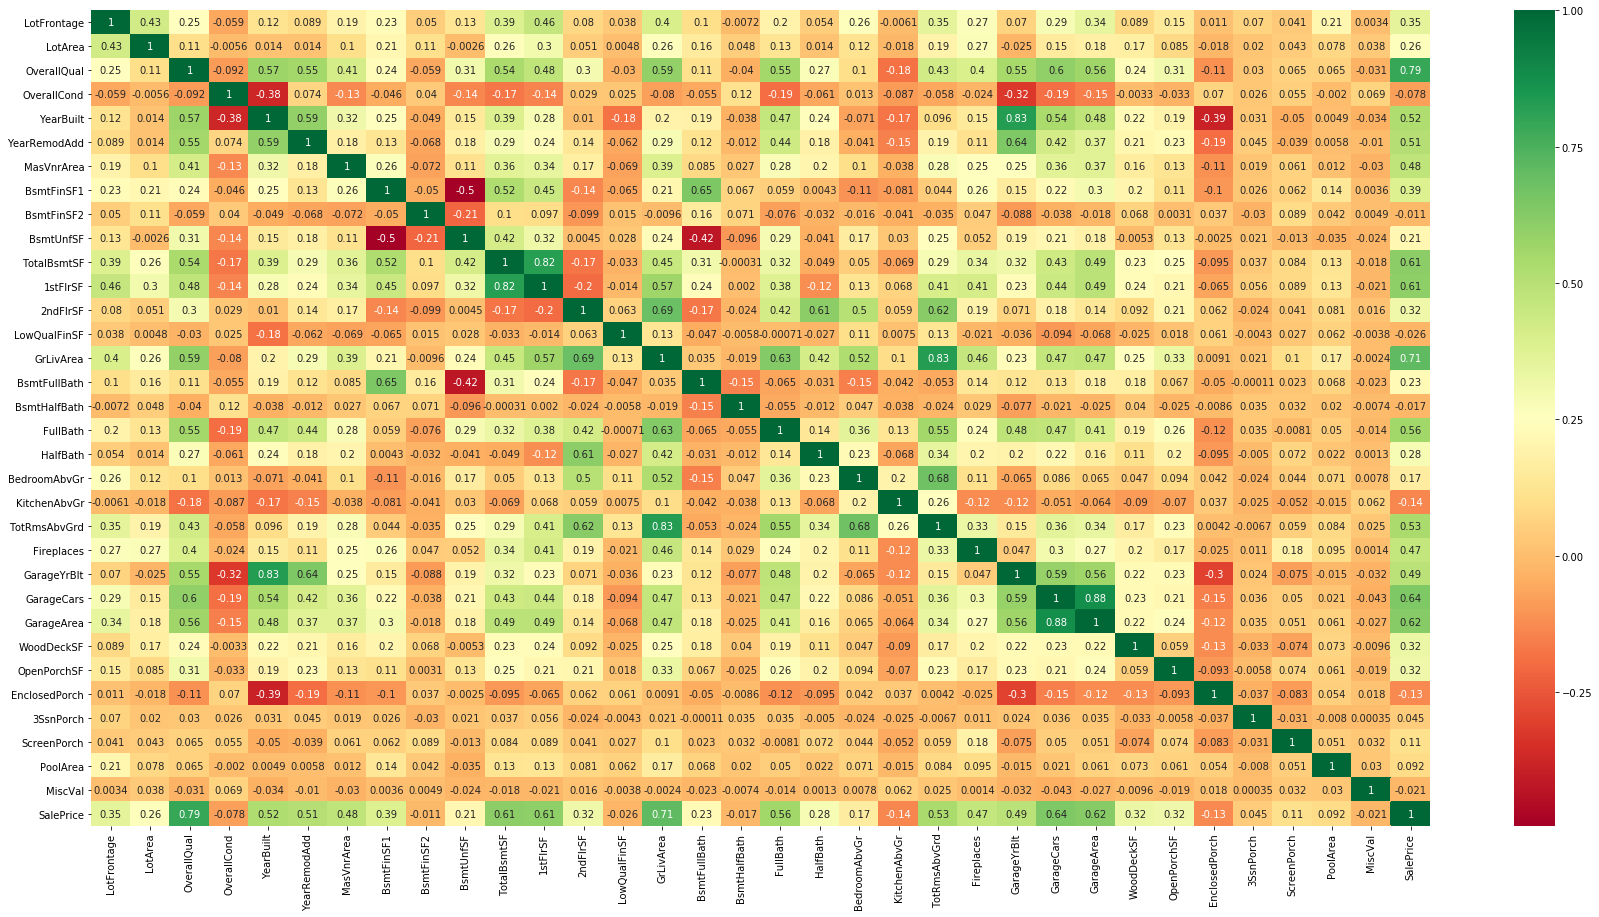

In [363]:
# correlation between numerical variables
corrmap = house_df.corr()
plt.figure(figsize=(30,15))
sns.heatmap(corrmap,annot=True,cmap="RdYlGn")
plt.show()

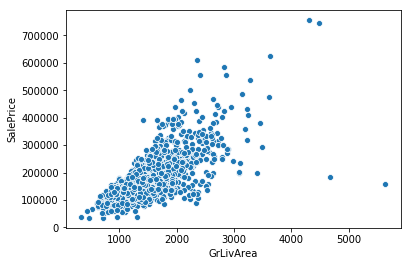

In [364]:
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = house_df)
plt.show()

In [485]:
house_df[(house_df['GrLivArea'] > 4000) & (house_df['SalePrice'] < 300000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [558]:
house_df = house_df.drop(house_df[(house_df['GrLivArea'] > 4000) & (house_df['SalePrice'] < 300000)].index)

## Organize response variable

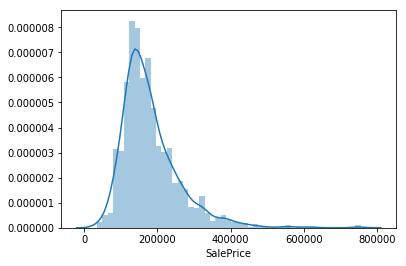

In [366]:
sns.distplot(a = house_df['SalePrice'])

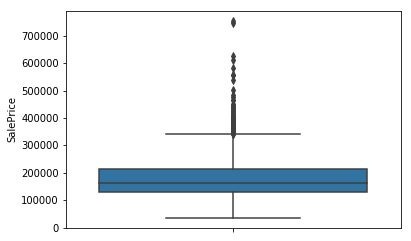

In [367]:
sns.boxplot(y = house_df['SalePrice'])
plt.show()

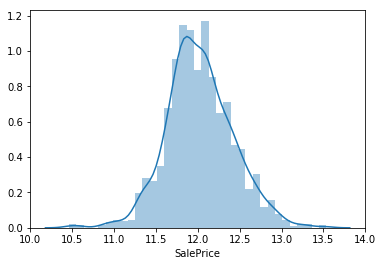

In [368]:
sns.distplot(a = np.log1p(house_df['SalePrice']))
plt.show()

In [489]:
y = np.log1p(house_df['SalePrice'])

## Check missing value

In [370]:
# train_data: calculate how many missng value of each columns and sort them from the maximum one
train_total_null = house_df.isnull().sum().sort_values(ascending = False)
# calculate the percentage
# in Python, Ture = 1 and False = 0, that's why we use sum and count to calculate the percentage
train_null_percent = (house_df.isnull().sum()/house_df.isnull().count()).sort_values(ascending = False)
# show the missing percentage and num
train_missing_value = pd.concat([train_total_null, train_null_percent], axis = 1, keys = ['train_total_null', 'train_null_percent'])
train_missing_value.head(20)

,train_total_null,train_null_percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageType,81,0.055556
GarageCond,81,0.055556
GarageFinish,81,0.055556
GarageQual,81,0.055556


In [371]:
# test_data missing value
test_total_null = test_data.isnull().sum().sort_values(ascending = False)
test_null_percent = (test_data.isnull().sum()/test_data.isnull().count()).sort_values(ascending = False)
test_missing_value = pd.concat([test_total_null, test_null_percent], axis = 1, keys = ['test_total_null', 'test_null_percent'])
test_missing_value.head(36)

,test_total_null,test_null_percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageFinish,78,0.053461
GarageYrBlt,78,0.053461
GarageQual,78,0.053461


In [372]:
# null related variables
sp = [i for i in house_df['PoolArea'] if i == 0]
print('number of PoolArea == 0: ', len(sp))
sm = [i for i in house_df['MiscVal'] if i == 0]
print('number of MiscVal == 0: ', len(sm))
sf = [i for i in house_df['Fireplaces'] if i == 0]
print('number of Fireplaces == 0: ', len(sf))
sg = [i for i in house_df['GarageArea'] if i == 0]
print('number of GarageArea == 0: ', len(sg))

number of PoolArea == 0:  1452
number of MiscVal == 0:  1406
number of Fireplaces == 0:  690
number of GarageArea == 0:  81


In [559]:
# I'll fill FireplaceQu null with 0
drop_missing = ['PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal', 'Alley', 'Fence']

# inapproperiate columns which could lead to data leakage
# any variable updated (or created) after the target value is realized should be excluded
unavailable_variables = ['SaleType', 'SaleCondition']

# total drop variables
drop_var = drop_missing + unavailable_variables

## Deal with missing value

In [560]:
# FireplaceQu
house_df['FireplaceQu'] = house_df['FireplaceQu'].fillna('None')

# garage related
garage_cat = ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']
house_df[garage_cat] = house_df[garage_cat].fillna('None')

garage_num = ['GarageYrBlt', 'GarageArea', 'GarageCars']
house_df[garage_num] = house_df[garage_num].fillna(0)

# basement related
bsmt_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
house_df[bsmt_cat] = house_df[bsmt_cat].fillna('None')

bsmt_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
house_df[bsmt_num] = house_df[bsmt_num].fillna(0)

# Masonry related
house_df['MasVnrType'] = house_df['MasVnrType'].fillna('None')

house_df['MasVnrArea'] = house_df['MasVnrArea'].fillna(0)

# mode fill
mode_fill = ['Electrical', 'Utilities', 'Functional', 'Exterior2nd', 'Exterior1st', 'KitchenQual', 'MSZoning']
for col in mode_fill:
	house_df[col] = house_df[col].fillna(house_df[col].mode()[0])

In [561]:
test_data['FireplaceQu'] = test_data['FireplaceQu'].fillna('None')

# garage related
garage_cat = ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']
test_data[garage_cat] = test_data[garage_cat].fillna('None')

garage_num = ['GarageYrBlt', 'GarageArea', 'GarageCars']
test_data[garage_num] = test_data[garage_num].fillna(0)

# basement related
bsmt_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
test_data[bsmt_cat] = test_data[bsmt_cat].fillna('None')

bsmt_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
test_data[bsmt_num] = test_data[bsmt_num].fillna(0)

# Masonry related
test_data['MasVnrType'] = test_data['MasVnrType'].fillna('None')

test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(0)

# mode fill
mode_fill = ['Electrical', 'Utilities', 'Functional', 'Exterior2nd', 'Exterior1st', 'KitchenQual', 'MSZoning']
for col in mode_fill:
	test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

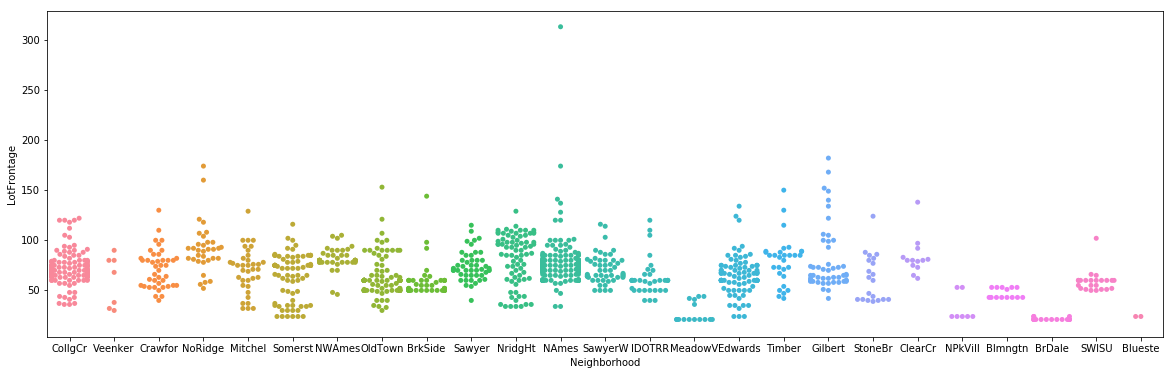

In [377]:
# LotFrontage
plt.subplots(figsize=(20, 6))
sns.swarmplot(x = 'Neighborhood', y = 'LotFrontage', data = house_df)
plt.show()

In [562]:
house_df['LotFrontage'] = house_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: 
	x.fillna(x.median()))

In [563]:
test_data['LotFrontage'] = test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: 
	x.fillna(x.median()))

## Pivot table

In [564]:
house_df = house_df.drop(drop_var, axis = 1)

In [565]:
test_data = test_data.drop(drop_var, axis = 1)

In [380]:
house_cat = house_df.select_dtypes(include = 'object')

In [381]:
mlt = pd.melt(house_df, id_vars = house_cat.columns, value_vars = ['SalePrice'])
mlt.head()


,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,variable,value
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,None,Attchd,RFn,TA,TA,Y,2,2008,SalePrice,208500
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,TA,Attchd,RFn,TA,TA,Y,5,2007,SalePrice,181500
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,Attchd,RFn,TA,TA,Y,9,2008,SalePrice,223500
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Gd,Detchd,Unf,TA,TA,Y,2,2006,SalePrice,140000
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,TA,Attchd,RFn,TA,TA,Y,12,2008,SalePrice,250000


In [382]:
for var in house_cat:
	a = (house_df.groupby(var)[var].count()/house_df.SalePrice.count()).round(4)*100
	b = pd.pivot_table(mlt, values = 'value', index = var, aggfunc = np.mean, margins = True)
	d = pd.pivot_table(mlt, values = 'value', index = var, aggfunc = np.std, margins = True)
	c = pd.concat([a,b,d], axis = 1, join = 'outer')
	display(c)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,MSSubClass,value,value
120,5.97,200779.080460,58221.490909
160,4.32,138647.380952,34587.542266
180,0.69,102300.000000,29474.282575
190,2.06,129613.333333,35439.097670
20,36.76,185224.811567,78782.189967
30,4.73,95829.724638,24857.110083
40,0.27,156125.000000,75747.799748
45,0.82,108591.666667,20231.723889
50,9.88,143302.972222,54851.983707
60,20.37,240403.542088,86686.994146


,MSZoning,value,value
All,NaN,180932.919067,79467.788930
C (all),0.69,74528.000000,33791.092031
FV,4.46,214014.061538,52369.662067
RH,1.10,131558.375000,35714.118435
RL,78.81,191037.422977,80831.267725
RM,14.95,126316.830275,48521.689833


,Street,value,value
All,NaN,180932.919067,79467.788930
Grvl,0.41,130190.500000,65446.253991
Pave,99.59,181142.598485,79499.338432


,LotShape,value,value
All,NaN,180932.919067,79467.788930
IR1,33.13,206145.871636,85941.994252
IR2,2.81,239833.365854,99669.427362
IR3,0.62,222262.777778,85019.978355
Reg,63.44,164754.818378,69673.427215


,LandContour,value,value
All,NaN,180932.919067,79467.788930
Bnk,4.18,142144.377049,49831.210475
HLS,3.43,231533.940000,101790.139741
Low,2.47,203661.111111,83935.353620
Lvl,89.92,180183.746758,78463.567918


,Utilities,value,value
All,NaN,180932.919067,79467.788930
AllPub,99.93,180962.728895,79514.197471
NoSeWa,0.07,137500.000000,NaN


,LotConfig,value,value
All,NaN,180932.919067,79467.788930
Corner,17.97,181705.958015,84617.073406
CulDSac,6.45,223854.617021,93117.546586
FR2,3.22,177934.574468,62788.926829
FR3,0.27,208475.000000,78379.222374
Inside,72.09,176930.614653,76462.810425


,LandSlope,value,value
All,NaN,180932.919067,79467.788930
Gtl,94.65,179967.787681,78724.455720
Mod,4.46,196734.138462,92375.358116
Sev,0.89,204379.230769,86729.922409


,Neighborhood,value,value
All,NaN,180932.919067,79467.788930
Blmngtn,1.17,194870.882353,30393.229219
Blueste,0.14,137500.000000,19091.883092
BrDale,1.10,104493.750000,14330.176493
BrkSide,3.98,124834.051724,40348.689270
ClearCr,1.92,212565.428571,50231.538993
CollgCr,10.29,197965.773333,51403.666438
Crawfor,3.50,210624.725490,68866.395472
Edwards,6.72,127318.571429,43142.801433
Gilbert,5.42,192854.506329,35986.779085


,Condition1,value,value
All,NaN,180932.919067,79467.788930
Artery,3.29,135091.666667,66226.660548
Feedr,5.49,142256.425000,42376.853783
Norm,86.42,184495.492063,81256.980125
PosA,0.55,225875.000000,52348.932313
PosN,1.23,216875.000000,66718.804673
RRAe,0.75,138400.000000,24030.813553
RRAn,1.78,184396.615385,66177.922070
RRNe,0.14,190750.000000,5303.300859
RRNn,0.34,212400.000000,93823.238060


,Condition2,value,value
All,NaN,180932.919067,79467.788930
Artery,0.14,106500.000000,16263.455967
Feedr,0.41,121166.666667,33544.994659
Norm,99.04,181184.065789,79363.263411
PosA,0.07,325000.000000,NaN
PosN,0.07,385000.000000,NaN
RRAe,0.07,190000.000000,NaN
RRAn,0.07,136905.000000,NaN
RRNn,0.14,96750.000000,39951.533137


,BldgType,value,value
1Fam,83.54,185785.792282,82713.081702
2fmCon,2.13,128432.258065,35458.545158
All,NaN,180932.919067,79467.788930
Duplex,3.57,133541.076923,27833.249197
Twnhs,2.95,135911.627907,41013.222080
TwnhsE,7.82,181959.342105,60626.108918


,HouseStyle,value,value
1.5Fin,10.56,143116.740260,54277.941119
1.5Unf,0.96,110150.000000,19036.473090
1Story,49.79,175985.477961,77055.715011
2.5Fin,0.55,220000.000000,118211.976671
2.5Unf,0.75,157354.545455,63934.128032
2Story,30.38,210221.862302,87495.768443
All,NaN,180932.919067,79467.788930
SFoyer,2.54,135074.486486,30480.898192
SLvl,4.46,166703.384615,38305.161339


,RoofStyle,value,value
All,NaN,180932.919067,79467.788930
Flat,0.89,194690.000000,62522.963515
Gable,78.26,171483.956179,66331.237296
Gambrel,0.75,148909.090909,67013.527807
Hip,19.48,219204.411972,111869.480171
Mansard,0.48,180568.428571,58057.624627
Shed,0.14,225000.000000,49497.474683


,RoofMatl,value,value
All,NaN,180932.919067,79467.788930
CompShg,98.29,179800.227495,77749.411655
Membran,0.07,241500.000000,NaN
Metal,0.07,180000.000000,NaN
Roll,0.07,137000.000000,NaN
Tar&Grv,0.75,185406.363636,65430.141720
WdShake,0.34,241400.000000,36218.779659
WdShngl,0.41,390250.000000,206969.019421


,Exterior1st,value,value
All,NaN,180932.919067,79467.788930
AsbShng,1.37,107385.550000,33756.480660
AsphShn,0.07,100000.000000,NaN
BrkComm,0.14,71000.000000,15556.349186
BrkFace,3.43,194573.000000,82841.914370
CBlock,0.07,105000.000000,NaN
CemntBd,4.12,232473.000000,121436.925001
HdBoard,15.23,163077.450450,66305.714164
ImStucc,0.07,262000.000000,NaN
MetalSd,15.09,149422.177273,54776.408990


,Exterior2nd,value,value
All,NaN,180932.919067,79467.788930
AsbShng,1.37,114060.550000,42315.043608
AsphShn,0.21,138000.000000,37509.998667
Brk Cmn,0.48,126714.285714,38693.084161
BrkFace,1.71,195818.000000,95097.551756
CBlock,0.07,105000.000000,NaN
CmentBd,4.05,230862.372881,116983.346492
HdBoard,14.20,167661.565217,70061.078357
ImStucc,0.69,252070.000000,193176.672447
MetalSd,14.68,149803.172897,55078.595310


,MasVnrType,value,value
All,NaN,180932.919067,79467.788930
BrkCmn,1.03,146318.066667,46187.583632
BrkFace,30.52,204691.871910,81214.293554
None,59.81,156958.243119,61491.688969
Stone,8.64,267063.126984,100020.903831


,ExterQual,value,value
All,NaN,180932.919067,79467.788930
Ex,3.43,375160.400000,111723.517706
Fa,0.96,87985.214286,39826.918794
Gd,33.47,231633.510246,71188.873899
TA,62.14,144341.313466,42471.815703


,ExterCond,value,value
All,NaN,180932.919067,79467.788930
Ex,0.21,201333.333333,109235.220205
Fa,1.92,102595.142857,40094.383940
Gd,10.01,168897.568493,72608.303632
Po,0.07,76500.000000,NaN
TA,87.79,184053.114844,79865.798079


,Foundation,value,value
All,NaN,180932.919067,79467.788930
BrkTil,10.01,132291.075342,54592.393032
CBlock,43.48,149805.714511,48295.041759
PConc,44.24,225394.334884,86947.991809
Slab,1.65,107365.625000,34213.980939
Stone,0.41,165959.166667,78557.704413
Wood,0.21,185666.666667,56695.090910


,BsmtQual,value,value
All,NaN,180932.919067,79467.788930
Ex,8.16,329640.470588,112695.762995
Fa,2.40,115692.028571,34469.667278
Gd,42.39,202688.478964,58092.364284
None,2.54,105652.891892,29278.694797
TA,44.51,140759.818182,43483.265311


,BsmtCond,value,value
All,NaN,180932.919067,79467.788930
Fa,3.09,121809.533333,43467.796975
Gd,4.46,213599.907692,72663.155026
None,2.54,105652.891892,29278.694797
Po,0.14,64000.000000,4242.640687
TA,89.78,183649.821238,79573.466015


,BsmtExposure,value,value
All,NaN,180932.919067,79467.788930
Av,15.16,206643.420814,88655.504849
Gd,9.05,258982.454545,119346.619097
Mn,7.82,192789.657895,77335.442652
No,65.36,165652.295908,60695.724915
None,2.61,107938.342105,32133.440664


,BsmtFinType1,value,value
ALQ,15.09,161573.068182,50821.277231
All,NaN,180932.919067,79467.788930
BLQ,10.15,149493.655405,47327.292126
GLQ,28.53,235716.790865,93332.977286
LwQ,5.08,151852.702703,50796.987083
None,2.54,105652.891892,29278.694797
Rec,9.12,146889.248120,45190.118879
Unf,29.49,170670.576744,72577.080129


,BsmtFinType2,value,value
ALQ,1.30,209942.105263,104764.743411
All,NaN,180932.919067,79467.788930
BLQ,2.26,151101.000000,41611.305388
GLQ,0.96,180982.142857,64573.040359
LwQ,3.16,164364.130435,43255.035241
None,2.61,110346.236842,40879.307312
Rec,3.70,164917.129630,59183.277020
Unf,86.01,184714.338915,81337.158455


,Heating,value,value
All,NaN,180932.919067,79467.788930
Floor,0.07,72500.000000,NaN
GasA,97.81,182034.724404,79316.297854
GasW,1.23,166632.166667,78547.575324
Grav,0.48,75271.428571,28066.570524
OthW,0.14,125750.000000,5303.300859
Wall,0.27,92100.000000,4509.988914


,HeatingQC,value,value
All,NaN,180932.919067,79467.788930
Ex,50.69,215029.556157,87557.701688
Fa,3.36,123919.489796,50306.618996
Gd,16.53,156858.871369,52923.920003
Po,0.07,87000.000000,NaN
TA,29.36,142362.876168,47226.485663


,CentralAir,value,value
All,NaN,180932.919067,79467.788930
N,6.52,105264.073684,40671.273961
Y,93.48,186206.976522,78859.841098


,Electrical,value,value
All,NaN,180932.919067,79467.788930
FuseA,6.45,122196.893617,37511.376615
FuseF,1.85,107675.444444,30636.507376
FuseP,0.21,97333.333333,34645.827070
Mix,0.07,67000.000000,NaN
SBrkr,91.43,186832.296324,79884.781874


,KitchenQual,value,value
All,NaN,180932.919067,79467.788930
Ex,6.72,331742.010204,119969.548649
Fa,2.67,105565.205128,36004.254037
Gd,40.19,212116.023891,64020.176702
TA,50.41,139962.511565,38896.280336


,Functional,value,value
All,NaN,180932.919067,79467.788930
Maj1,0.96,153948.142857,64503.775815
Maj2,0.34,85800.000000,27086.897201
Min1,2.13,146385.483871,38089.572487
Min2,2.33,144240.647059,41215.354652
Mod,1.03,168393.333333,118938.666467
Sev,0.07,129000.000000,NaN
Typ,93.14,183445.427099,80074.369250


,FireplaceQu,value,value
All,NaN,180932.919067,79467.788930
Ex,1.65,337712.500000,123611.471764
Fa,2.26,167298.484848,34287.717564
Gd,25.93,226637.005291,91275.013033
None,47.33,141331.482609,44389.786884
Po,1.37,129764.150000,31080.842115
TA,21.47,205723.488818,71367.028772


,GarageType,value,value
2Types,0.41,151283.333333,34917.068415
All,NaN,180932.919067,79467.788930
Attchd,59.60,202942.014960,77177.301935
Basment,1.30,160570.684211,63967.283574
BuiltIn,5.97,255556.356322,102542.859575
CarPort,0.62,109962.111111,24638.183681
Detchd,26.54,134091.162791,41391.549953
None,5.56,103317.283951,32815.023389


,GarageFinish,value,value
All,NaN,180932.919067,79467.788930
Fin,24.01,240439.420000,97097.667633
None,5.56,103317.283951,32815.023389
RFn,28.94,202068.869668,63536.222518
Unf,41.50,142156.423140,46498.528211


,GarageQual,value,value
All,NaN,180932.919067,79467.788930
Ex,0.21,241000.000000,202680.166765
Fa,3.29,123573.354167,42971.440985
Gd,0.96,215860.714286,74126.739021
None,5.56,103317.283951,32815.023389
Po,0.21,100166.666667,35143.752408
TA,89.78,187512.929717,78831.446924


,GarageCond,value,value
All,NaN,180932.919067,79467.788930
Ex,0.14,124000.000000,4949.747468
Fa,2.40,114654.028571,36420.903588
Gd,0.62,179930.000000,64769.318354
None,5.56,103317.283951,32815.023389
Po,0.48,108500.000000,22662.377045
TA,90.81,187909.165408,79159.328057


,PavedDrive,value,value
All,NaN,180932.919067,79467.788930
N,6.17,115039.122222,44352.523309
P,2.06,132330.000000,33503.030228
Y,91.77,186454.988789,79721.772211


,MoSold,value,value
1,3.91,183664.263158,122419.915586
10,6.04,179505.045455,76167.976759
11,5.42,192210.911392,83517.711202
12,4.05,186518.966102,69495.155055
2,3.57,177882.000000,52960.863135
3,7.27,183253.924528,86488.445599
4,9.67,171503.262411,77147.323106
5,13.99,172307.269608,68614.545198
6,17.35,177395.735178,69453.085881
7,16.05,186331.192308,91772.125395


,YrSold,value,value
2006,21.54,182549.458599,79426.838855
2007,22.50,186067.155488,85899.184505
2008,20.78,177418.135314,69843.803786
2009,23.18,179432.103550,80879.237311
2010,12.00,177393.674286,80451.280085
All,NaN,180932.919067,79467.788930


In [566]:
bad_cat = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [567]:
house_df = house_df.drop(bad_cat, axis = 1)

In [568]:
test_data = test_data.drop(bad_cat, axis = 1)

## Numeric features

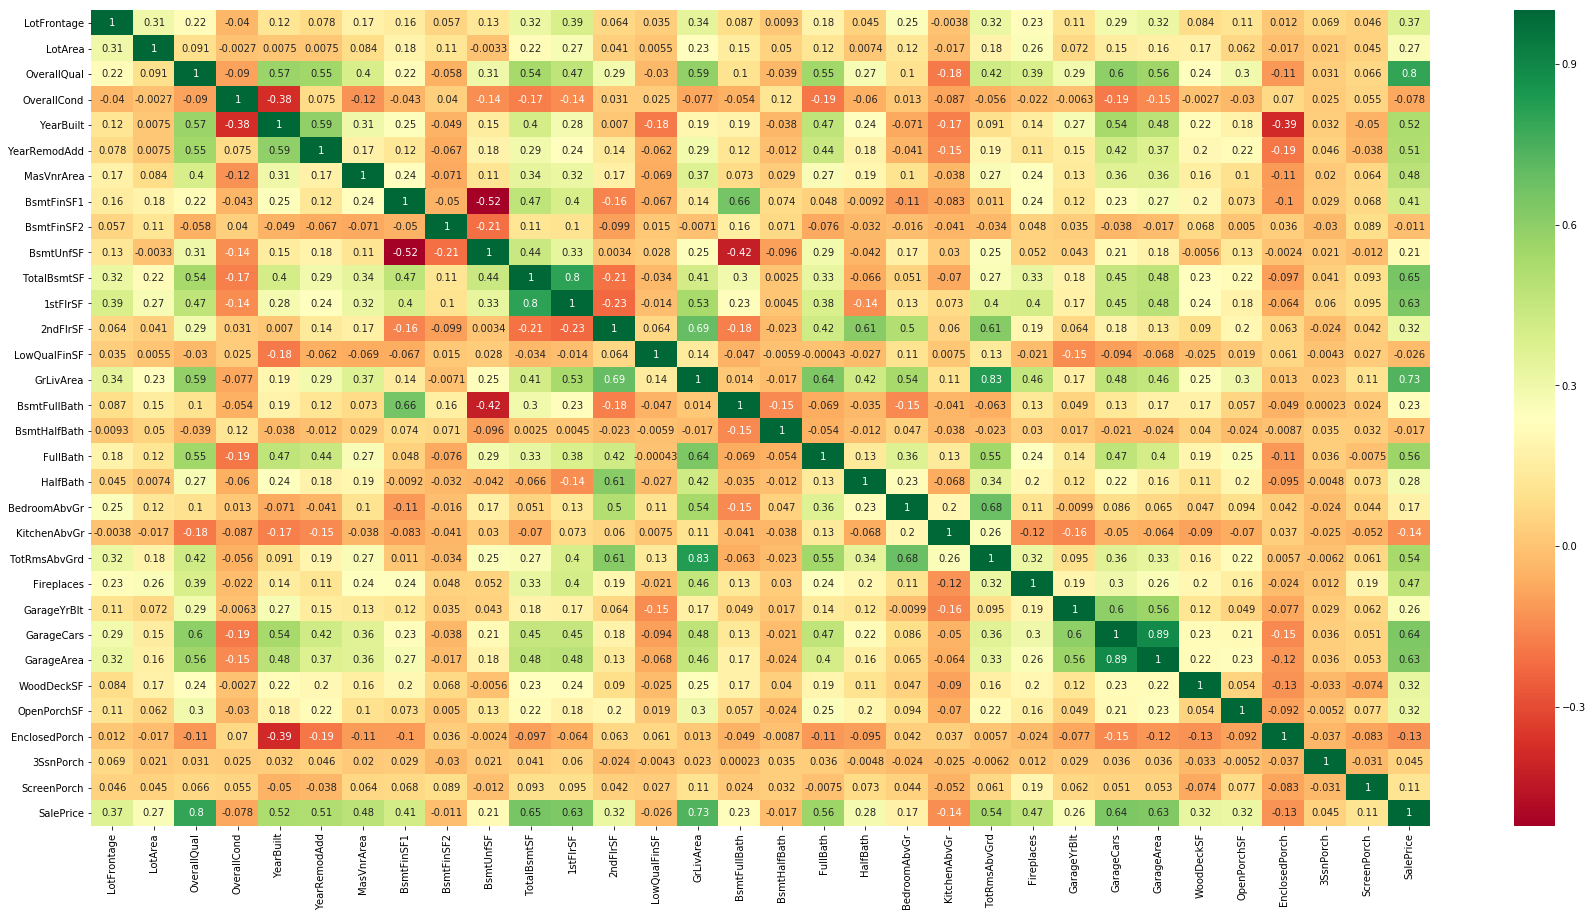

In [385]:
# correlation between numerical variables
corrmap = house_df.corr()
plt.figure(figsize=(30,15))
sns.heatmap(corrmap,annot=True,cmap="RdYlGn")
plt.show()

### check 0 of numeric variables

In [386]:
zero_count = (1460 - house_df.astype(bool).sum(axis=0)).sort_values(ascending = False)
zero_percent = ((1460-house_df.astype(bool).sum(axis=0))/house_df.astype(bool).count(axis=0)).sort_values(ascending = False)
house_zero = pd.concat([zero_count, zero_percent], axis = 1, keys = ['zero_count', 'zero_percent'])
house_zero.head(25)

,zero_count,zero_percent
3SsnPorch,1436,0.984911
LowQualFinSF,1434,0.983539
BsmtHalfBath,1378,0.945130
ScreenPorch,1344,0.921811
BsmtFinSF2,1293,0.886831
EnclosedPorch,1252,0.858711
HalfBath,915,0.627572
MasVnrArea,871,0.597394
BsmtFullBath,858,0.588477
2ndFlrSF,831,0.569959


### group related features

In [569]:
# area
# total finished basement square feet
house_df['BsmtFinSF'] = house_df['BsmtFinSF1'] + house_df['BsmtFinSF2'] 

# total house squrae feet
house_df['TotalHouseSF'] = house_df['TotalBsmtSF'] + house_df['GrLivArea'] 

# whether has more than one floor
def is1fl(row):
    if row['2ndFlrSF'] > 0:
        return 1
    return 0
house_df['is_over_1fl'] = house_df.apply(lambda row: is1fl(row), axis=1)


# porch area
house_df['TotalPorchSF'] = house_df['OpenPorchSF'] + house_df['EnclosedPorch'] + house_df['3SsnPorch'] 
+ house_df['ScreenPorch']

# bathrooms
house_df['TotalBath'] = house_df['BsmtFullBath'] + 0.5*house_df['BsmtHalfBath'] 
+ house_df['FullBath'] + 0.5*house_df['HalfBath']

# year remode and build
house_df['YearBuiltRemodeAvg'] = (house_df['YearBuilt'] + house_df['YearRemodAdd'])/2

house_df.shape

(1458, 73)

In [570]:
# area
# total finished basement square feet
test_data['BsmtFinSF'] = test_data['BsmtFinSF1'] + test_data['BsmtFinSF2'] 

# total house squrae feet
test_data['TotalHouseSF'] = test_data['TotalBsmtSF'] + test_data['GrLivArea'] 

# whether has more than one floor
def is1fl(row):
    if row['2ndFlrSF'] > 0:
        return 1
    return 0
test_data['is_over_1fl'] = test_data.apply(lambda row: is1fl(row), axis=1)


# porch area
test_data['TotalPorchSF'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + test_data['3SsnPorch'] 
+ test_data['ScreenPorch']

# bathrooms
test_data['TotalBath'] = test_data['BsmtFullBath'] + 0.5*test_data['BsmtHalfBath'] 
+ test_data['FullBath'] + 0.5*test_data['HalfBath']

# year remode and build
test_data['YearBuiltRemodeAvg'] = (test_data['YearBuilt'] + test_data['YearRemodAdd'])/2

test_data.shape

(1459, 72)

In [571]:
group_zero_drop_var = ['BsmtFinSF1', 'BsmtFinSF2', '2ndFlrSF', '1stFlrSF', 'OpenPorchSF', 'EnclosedPorch',
'3SsnPorch', 'ScreenPorch', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'LowQualFinSF']
house_df = house_df.drop(group_zero_drop_var, axis = 1)

In [572]:
test_data = test_data.drop(group_zero_drop_var, axis = 1)

In [389]:
house_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'MoSold', 'YrSold', 'SalePrice',
       'BsmtFinSF', 'TotalHouseSF', 'is_over_1fl', 'TotalPorchSF', 'TotalBath',
       'YearBuiltRemodeAvg'],
      dtype='object')

In [390]:
zero_count = (1460 - house_df.astype(bool).sum(axis=0)).sort_values(ascending = False)
zero_percent = ((1460-house_df.astype(bool).sum(axis=0))/house_df.astype(bool).count(axis=0)).sort_values(ascending = False)
house_zero = pd.concat([zero_count, zero_percent], axis = 1, keys = ['zero_count', 'zero_percent'])
house_zero.head(15)

,zero_count,zero_percent
MasVnrArea,871,0.597394
is_over_1fl,831,0.569959
TotalBath,785,0.538409
WoodDeckSF,763,0.523320
Fireplaces,692,0.474623
TotalPorchSF,507,0.347737
BsmtFinSF,469,0.321674
BsmtUnfSF,120,0.082305
GarageArea,83,0.056927
GarageYrBlt,83,0.056927


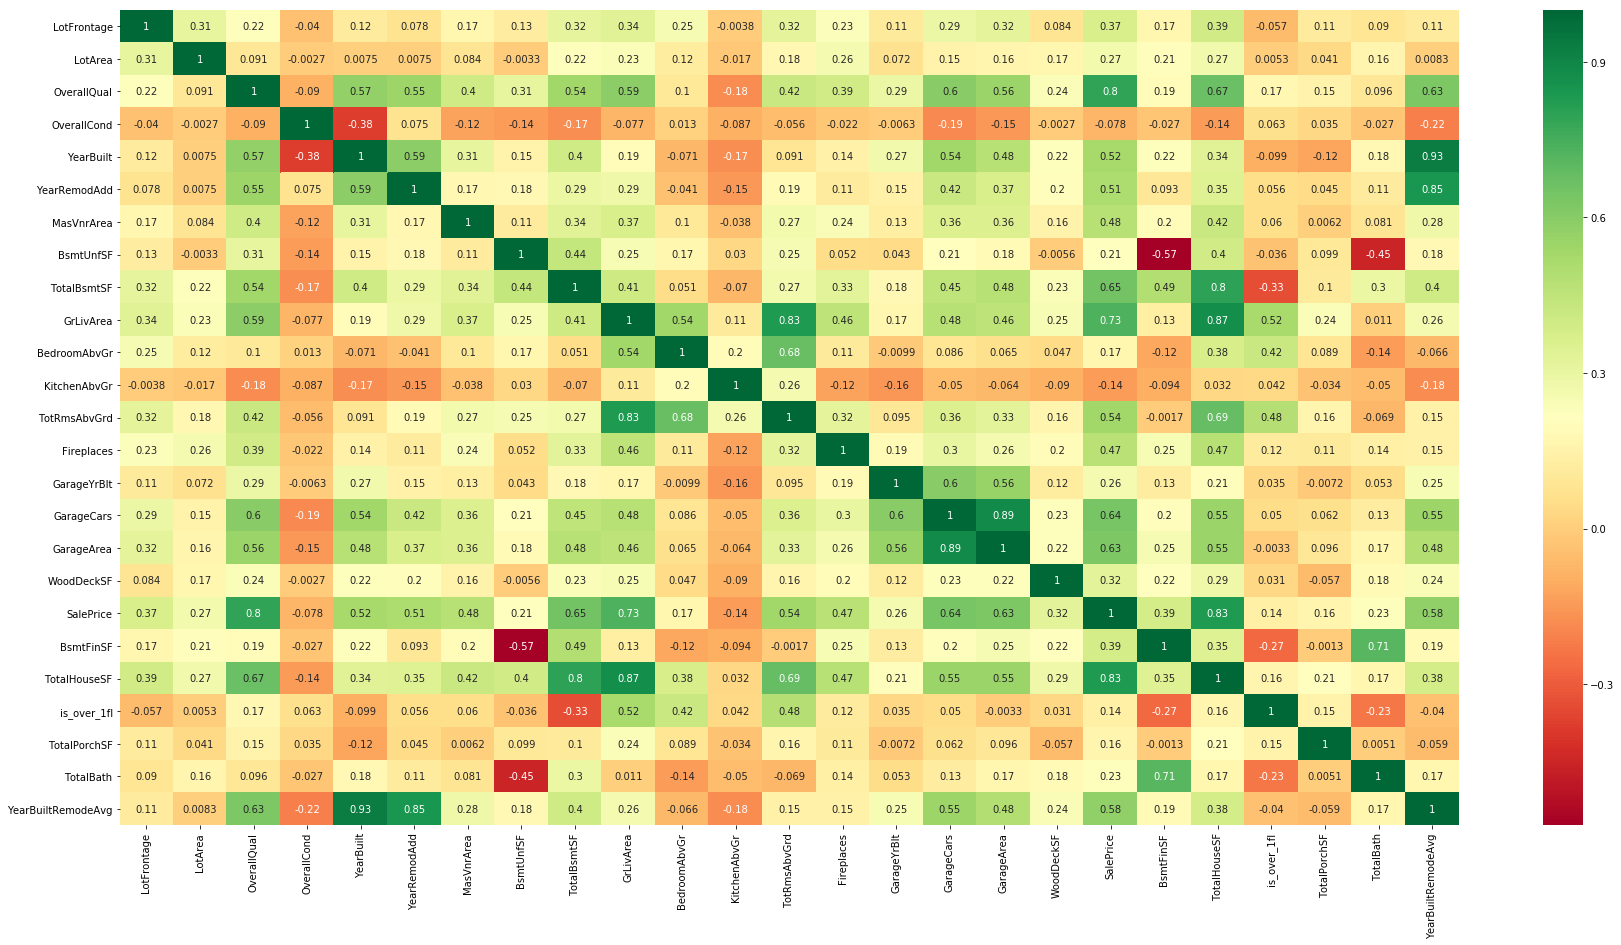

In [391]:
# correlation between numerical variables
corrmap = house_df.corr()
plt.figure(figsize=(30,15))
sns.heatmap(corrmap,annot=True,cmap="RdYlGn")
plt.show()

## transform features

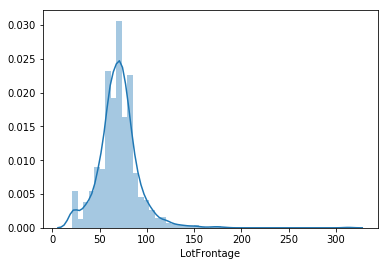

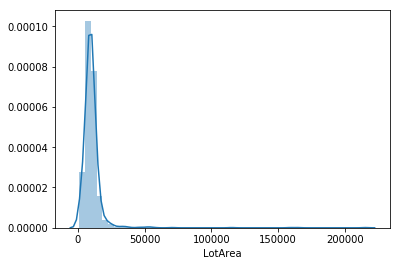

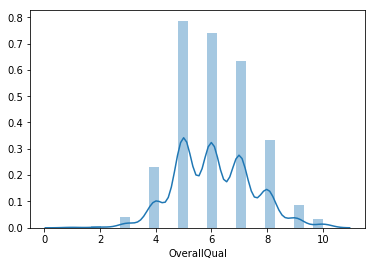

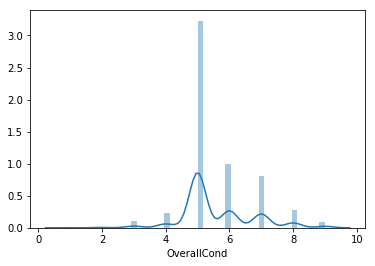

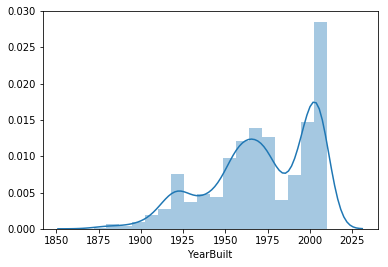

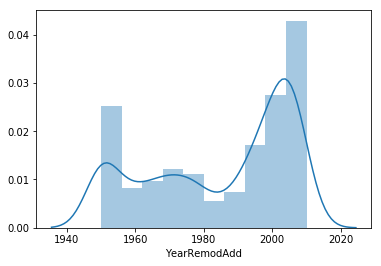

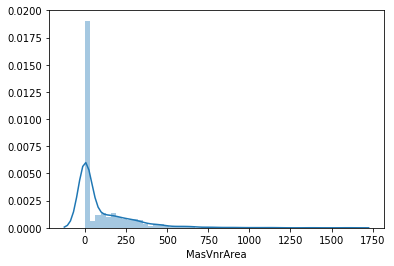

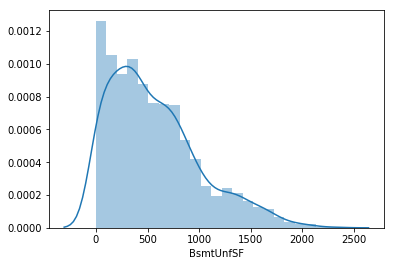

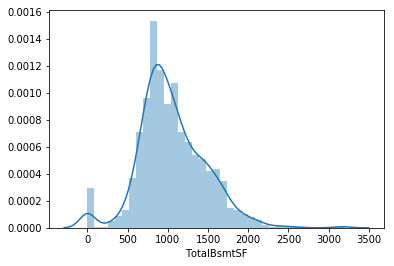

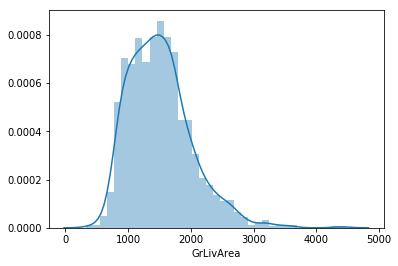

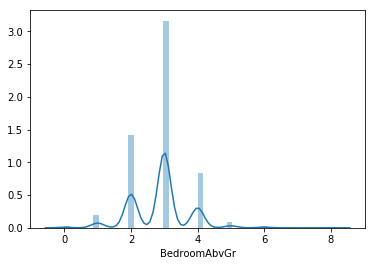

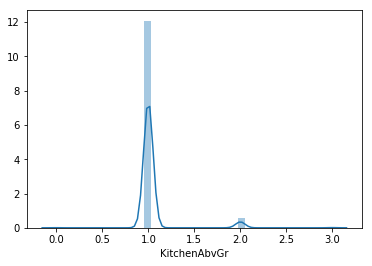

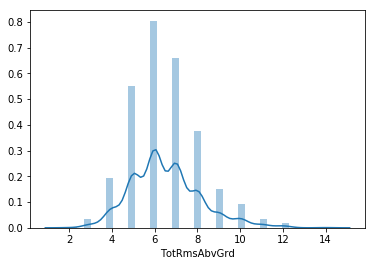

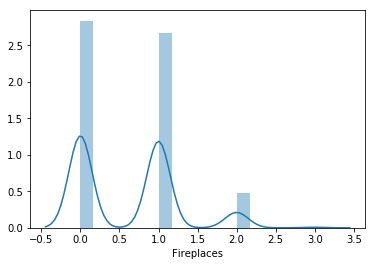

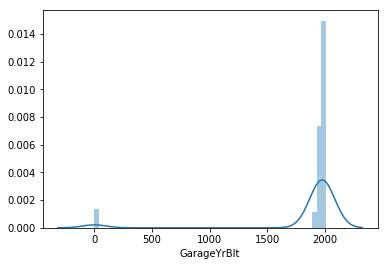

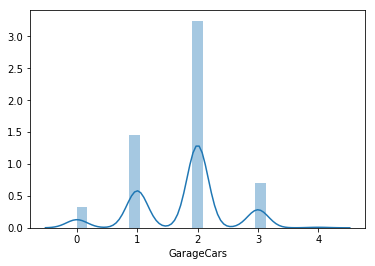

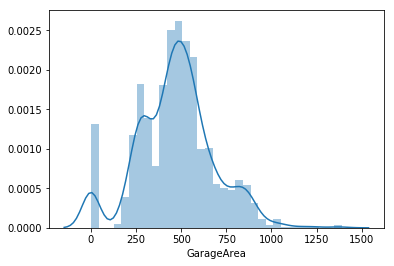

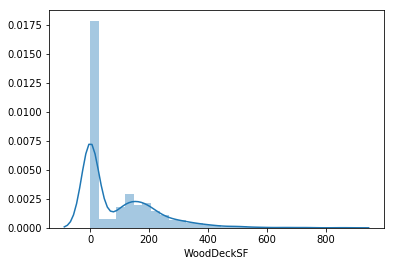

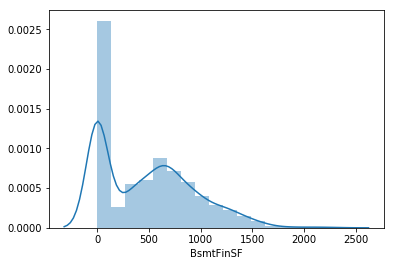

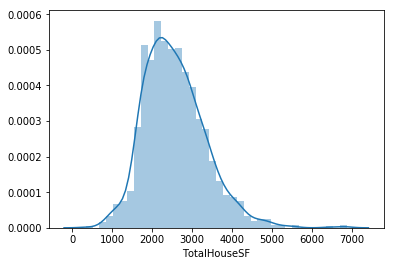

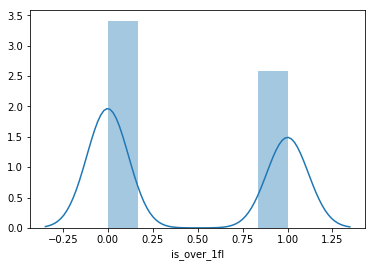

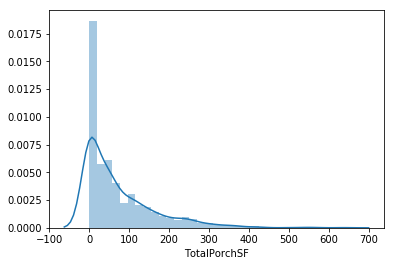

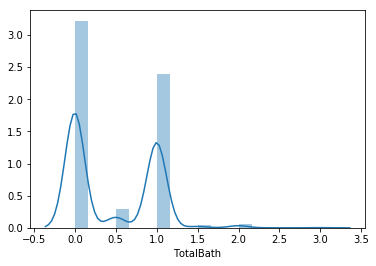

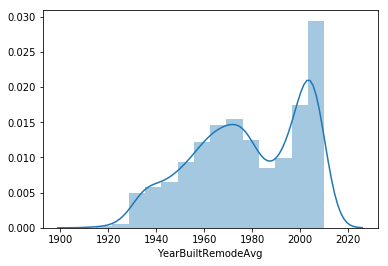

In [392]:
# check the distribution of each numeric feature
house_num = house_df.select_dtypes(exclude = 'object').drop('SalePrice', axis = 1)
for column in house_num:
    sns.distplot(a = house_df[column])
    plt.show()

### skewness

In [402]:
house_num = house_df.select_dtypes(exclude = 'object').drop('SalePrice', axis = 1)

skewness = house_num.apply(lambda x: skew(x)).sort_values(ascending=False)

skewness_df = pd.DataFrame({'Skewness': skewness})
skewness_df

,Skewness
LotArea,12.560986
KitchenAbvGr,4.480268
MasVnrArea,2.693554
TotalPorchSF,1.819471
LotFrontage,1.546624
WoodDeckSF,1.544214
GrLivArea,1.009951
BsmtUnfSF,0.919955
TotalHouseSF,0.816240
OverallCond,0.690324


In [403]:
(abs(skewness) > 0.75).value_counts()

False    14
True     10
dtype: int64

In [573]:
boxcox_features = skewness_df[np.abs(skewness_df['Skewness'])>0.75].index
lam = 0.15

for col in boxcox_features:
    house_df.loc[:, col] = boxcox1p(house_df[col], lam)

In [574]:
for col in boxcox_features:
    test_data.loc[:, col] = boxcox1p(test_data[col], lam)

In [407]:
house_num_col = house_num.columns
skewness2 = house_df[house_num_col].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness_df2 = pd.DataFrame({'Skewness': skewness2})
skewness_df2.head(10)

,Skewness
KitchenAbvGr,3.992521
LotArea,0.710724
OverallCond,0.690324
TotRmsAbvGrd,0.659822
Fireplaces,0.631409
BsmtFinSF,0.606357
MasVnrArea,0.606190
TotalBath,0.513088
TotalBsmtSF,0.511177
is_over_1fl,0.276967


In [408]:
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,MoSold,YrSold,SalePrice,BsmtFinSF,TotalHouseSF,is_over_1fl,TotalPorchSF,TotalBath,YearBuiltRemodeAvg
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,5.831328,19.212182,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,0.000000,2,2008,208500,706,14.976591,1,5.714669,1.0,2003.0
2,20,RL,6.221214,19.712205,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,9.010206,5,2007,181500,978,14.923100,0,0.000000,0.5,1976.0
3,60,RL,5.914940,20.347241,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,0.000000,9,2008,223500,486,15.149678,1,5.053371,1.0,2001.5
4,70,RL,5.684507,19.691553,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,0.000000,2,2006,140000,216,14.857121,1,9.080098,1.0,1942.5
5,60,RL,6.314735,21.325160,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,8.013884,12,2008,250000,655,15.852312,1,6.314735,1.0,2000.0


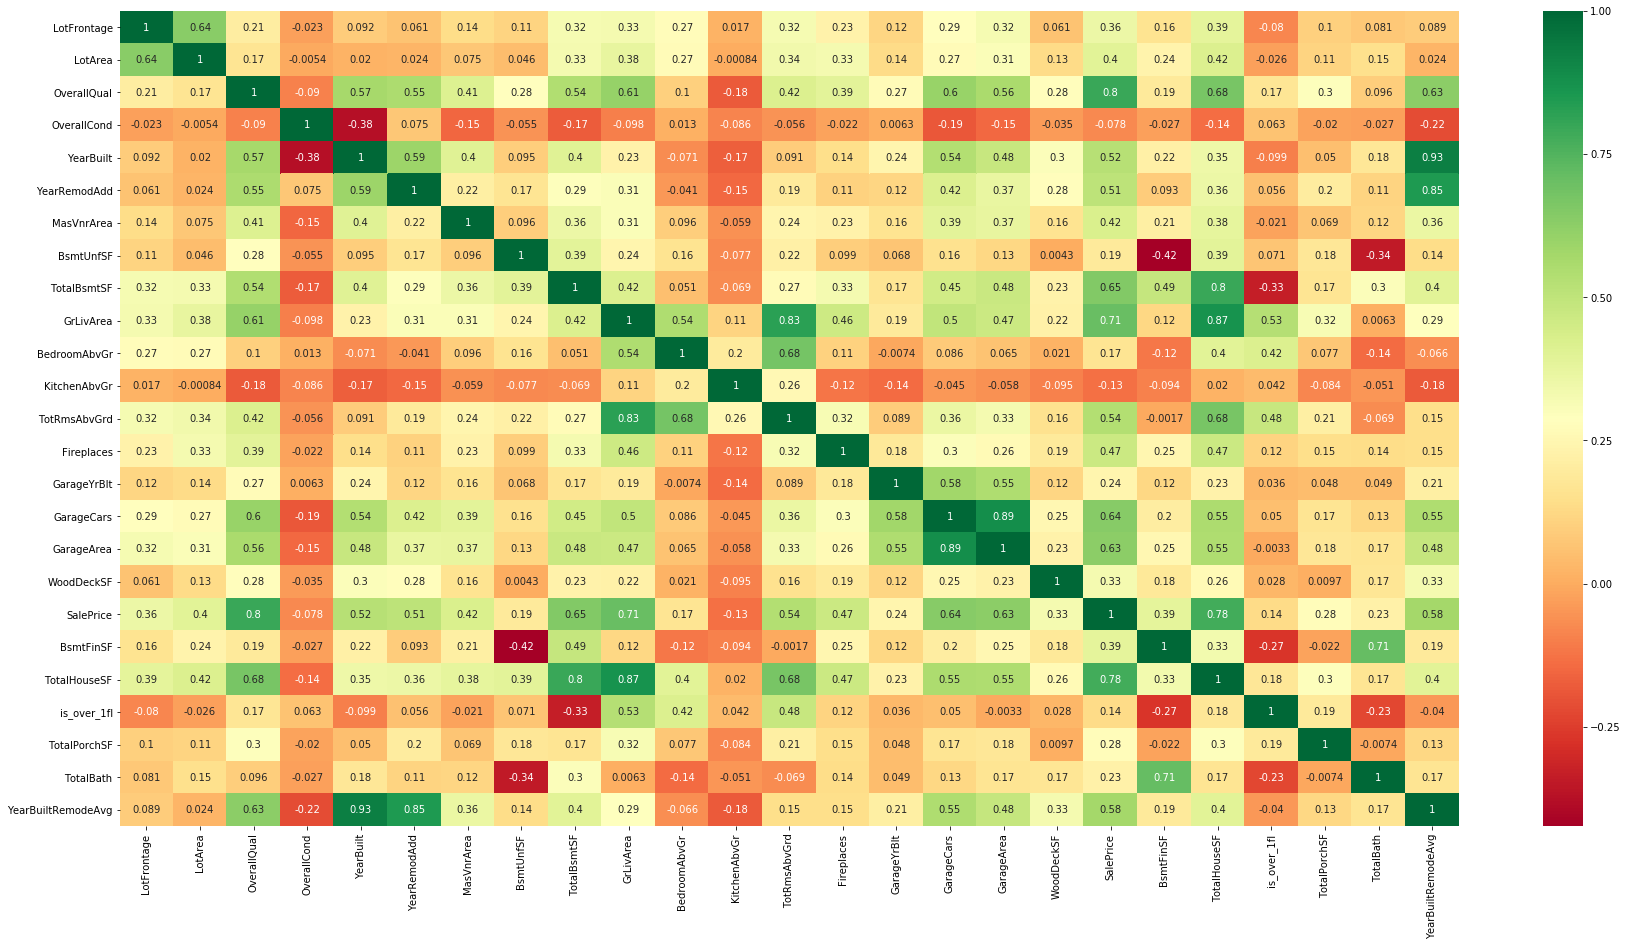

In [409]:
# correlation between numerical variables
corrmap = house_df.corr()
plt.figure(figsize=(30,15))
sns.heatmap(corrmap,annot=True,cmap="RdYlGn")
plt.show()

# Get dummies

In [575]:
train_test_combine = pd.concat([house_df.drop('SalePrice', axis = 1),test_data], axis = 0, join = 'outer')

In [576]:
train_test_combine.shape

(2917, 59)

In [577]:
train_test_combine.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,PavedDrive,WoodDeckSF,MoSold,YrSold,BsmtFinSF,TotalHouseSF,is_over_1fl,TotalPorchSF,TotalBath,YearBuiltRemodeAvg
Id,,,,,,,,,,,,,,,,,,,,,
2915,160,RM,3.932510,14.081426,Reg,Lvl,Inside,Gtl,MeadowV,Norm,...,Y,0.000000,6,2006,0.0,13.567978,1,0.000000,0.0,1970.0
2916,160,RM,3.932510,14.013314,Reg,Lvl,Inside,Gtl,MeadowV,Norm,...,Y,0.000000,4,2006,252.0,13.567978,1,4.137711,0.0,1970.0
2917,20,RL,7.620056,22.782058,Reg,Lvl,Inside,Gtl,Mitchel,Norm,...,Y,10.137338,9,2006,1224.0,14.824355,0,0.000000,1.0,1978.0
2918,85,RL,5.744420,20.046557,Reg,Lvl,Inside,Gtl,Mitchel,Norm,...,Y,6.221214,7,2006,337.0,13.993617,0,4.597157,0.5,1992.0
2919,60,RL,6.073289,19.723319,Reg,Lvl,Inside,Mod,Mitchel,Norm,...,Y,7.990963,11,2006,758.0,15.485273,1,5.285266,0.0,1993.5


In [578]:
X_train_test = pd.get_dummies(train_test_combine)

In [579]:
X_train_test.shape

(2917, 265)

In [580]:
house_df.shape

(1458, 60)

In [581]:
X_final = X_train_test.iloc[:1458,:]

In [583]:
X_final.shape

(1458, 265)

In [584]:
X_test = X_train_test.iloc[1458:,:]

In [585]:
X_test.shape

(1459, 265)

In [586]:
X_test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,TotalBsmtSF,GrLivArea,...,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
Id,,,,,,,,,,,,,,,,,,,,,
1461,6.221214,20.479373,5,6,1961,1961,0.000000,8.780689,882.0,11.818680,...,0,1,0,0,0,0,0,0,0,1
1462,6.244956,21.327220,6,6,1958,1958,6.808145,9.752379,1329.0,12.943735,...,0,1,0,0,0,0,0,0,0,1
1463,6.073289,21.196905,5,5,1997,1998,0.000000,7.293500,928.0,13.551272,...,0,0,0,0,0,0,0,0,0,1
1464,6.172972,19.865444,6,6,1998,1998,3.858807,9.207511,926.0,13.504453,...,0,1,0,0,0,0,0,0,0,1
1465,5.093857,17.257255,8,5,1992,1992,0.000000,12.172900,1280.0,12.833625,...,0,0,0,0,0,0,0,0,0,1


# Model

In [587]:
X_train, X_valid, y_train, y_valid = train_test_split(X_final, y, train_size=0.8, random_state=1)


In [588]:
# Define the model
my_model = XGBRegressor(n_estimators = 1000, learning_rate = 0.05) 

# Fit the model
my_model.fit(X_train, y_train, early_stopping_rounds = 5, eval_set = [(X_valid, y_valid)]) 

# Get predictions
y_predict = my_model.predict(X_valid) # Your code here


[09:44:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.9429
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:10.3962
[2]	validation_0-rmse:9.87682
[3]	validation_0-rmse:9.38344
[4]	validation_0-rmse:8.91476
[5]	validation_0-rmse:8.46978
[6]	validation_0-rmse:8.04807
[7]	validation_0-rmse:7.64644
[8]	validation_0-rmse:7.26465
[9]	validation_0-rmse:6.90304


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10]	validation_0-rmse:6.55866
[11]	validation_0-rmse:6.23094
[12]	validation_0-rmse:5.92012
[13]	validation_0-rmse:5.62556
[14]	validation_0-rmse:5.34452
[15]	validation_0-rmse:5.07803
[16]	validation_0-rmse:4.82554
[17]	validation_0-rmse:4.58582
[18]	validation_0-rmse:4.35815
[19]	validation_0-rmse:4.14085
[20]	validation_0-rmse:3.93527
[21]	validation_0-rmse:3.73949
[22]	validation_0-rmse:3.55396
[23]	validation_0-rmse:3.37793
[24]	validation_0-rmse:3.21005
[25]	validation_0-rmse:3.05117
[26]	validation_0-rmse:2.90021
[27]	validation_0-rmse:2.75686
[28]	validation_0-rmse:2.62051
[29]	validation_0-rmse:2.4906
[30]	validation_0-rmse:2.3676
[31]	validation_0-rmse:2.25089
[32]	validation_0-rmse:2.14018
[33]	validation_0-rmse:2.03474
[34]	validation_0-rmse:1.93457
[35]	validation_0-rmse:1.83949
[36]	validation_0-rmse:1.74899
[37]	validation_0-rmse:1.66355
[38]	validation_0-rmse:1.58207
[39]	validation_0-rmse:1.50508
[40]	validation_0-rmse:1.43118
[41]	validation_0-rmse:1.36091
[42]	valid

[264]	validation_0-rmse:0.118268
[265]	validation_0-rmse:0.118241
[266]	validation_0-rmse:0.118227
[267]	validation_0-rmse:0.118225
[268]	validation_0-rmse:0.118083
[269]	validation_0-rmse:0.118059
[270]	validation_0-rmse:0.118013
[271]	validation_0-rmse:0.117985
[272]	validation_0-rmse:0.117933
[273]	validation_0-rmse:0.117943
[274]	validation_0-rmse:0.117836
[275]	validation_0-rmse:0.117777
[276]	validation_0-rmse:0.117772
[277]	validation_0-rmse:0.117797
[278]	validation_0-rmse:0.117737
[279]	validation_0-rmse:0.117708
[280]	validation_0-rmse:0.117701
[281]	validation_0-rmse:0.11764
[282]	validation_0-rmse:0.117625
[283]	validation_0-rmse:0.117584
[284]	validation_0-rmse:0.117599
[285]	validation_0-rmse:0.117613
[286]	validation_0-rmse:0.117608
[287]	validation_0-rmse:0.117604
[288]	validation_0-rmse:0.117582
[289]	validation_0-rmse:0.117574
[290]	validation_0-rmse:0.117548
[291]	validation_0-rmse:0.117541
[292]	validation_0-rmse:0.117553
[293]	validation_0-rmse:0.117501
[294]	valid

In [589]:
regressionSummary(y_predict, y_valid)


Regression statistics

                      Mean Error (ME) : -0.0040
       Root Mean Squared Error (RMSE) : 0.1173
            Mean Absolute Error (MAE) : 0.0852
          Mean Percentage Error (MPE) : -0.0324
Mean Absolute Percentage Error (MAPE) : 0.7154


In [590]:
SalePriceArray = my_model.predict(X_test) # Your code here


In [591]:
SalePrice_final = np.expm1(SalePriceArray)

In [594]:
output = pd.DataFrame({'Id': test_data.index,
                      'SalePrice': SalePrice_final})
output.to_csv('submission.csv', index=False)

In [596]:
output.head()

,Id,SalePrice
0,1461,121156.125000
1,1462,161644.546875
2,1463,183394.281250
3,1464,187828.796875
4,1465,183129.140625
